In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.special
import imageio # type: ignore

In [2]:
#Класс нейронной сети
class neuralNetwork:
    #Инициализация нейронной сети
    def __init__(self, count_input_nodes, count_hidden_nodes, 
            count_out_nodes, lerning_rate) -> None:
        #Количество: входных, скрытых и выходных узлов
        self.count_input_nodes = count_input_nodes
        self.count_hidden_nodes = count_hidden_nodes
        self.count_out_nodes = count_out_nodes

        #Коэффицент обучения
        self.lerning_rate = lerning_rate


        # Матрицы весовых коэффициентов связей wih (между входным и скрытым
        # слоями) и who (между скрытым и выходным слоями).
        # Весовые коэффициенты связей между узлом i и узлом j следующего слоя
        # обозначены как w_i_j:
        # wll w21
        # wl2 w22 и т.д.
        self.weight_input_hidden = numpy.random.normal(0.0, pow(self.count_hidden_nodes, -0.5), 
            (self.count_hidden_nodes, self.count_input_nodes))
        
        self.weight_hidden_out = numpy.random.normal(0.0, pow(self.count_out_nodes, -0.5), 
            (self.count_out_nodes, self.count_hidden_nodes))


        # использование сигмоиды в качестве функции активации 
        self.sigmoid_function = lambda x: scipy.special.expit(x)

        self.inverse_function = lambda x: scipy.special.logit(x)
    
    #Тренировка нейронной сети
    def train(self, inputs_list, targets_list):
        # активация опроса сети
        self.quary(inputs_list)
        

        # преобразовать список входных значений в двухмерный массив 
        targets = numpy.array(targets_list, ndmin=2).T


        # получить величины ошибок для каждого выходного узла
        output_errors = targets - self.final_outputs
        
        # ошибки скрытого слоя - это ошибки output_errors,
        # распределенные пропорционально весовым коэффициентам связей
        # и рекомбинированные на скрытых узлах 
        hidden_errors = numpy.dot(self.weight_hidden_out.T, output_errors)


        # обновить весовые коэффициенты связей между скрытым и выходным слоями 
        self.weight_hidden_out += self.lerning_rate * numpy.dot(
            (output_errors * self.final_outputs * (1.0 - self.final_outputs)), numpy.transpose(self.hidden_outputs))
        
        # обновить весовые коэффициенты связей между входным и скрытым слоями 
        self.weight_input_hidden += self.lerning_rate * numpy.dot(
            (hidden_errors * self.hidden_outputs * (1.0 - self.hidden_outputs)), numpy.transpose(self.inputs))

    #Опрос нейронной сети
    def quary(self, inputs_list):
        # преобразовать список входных значений
        # в двухмерный массив
        self.inputs = numpy.array(inputs_list, ndmin=2).T
        
        # рассчитать входящие сигналы для скрытого слоя 
        hidden_inputs = numpy.dot(self.weight_input_hidden, self.inputs)
        # рассчитать исходящие сигналы для скрытого слоя 
        self.hidden_outputs = self.sigmoid_function(hidden_inputs)
        
        # рассчитать входящие сигналы для выходного слоя 
        final_inputs = numpy.dot(self.weight_hidden_out, self.hidden_outputs)
        # рассчитать исходящие сигналы для выходного слоя 
        self.final_outputs = self.sigmoid_function(final_inputs)

        return self.final_outputs
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.weight_hidden_out.T, final_inputs)
        
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.weight_input_hidden.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [3]:
# количество входных, скрытых и выходных узлов 
input_nodes = 784
hidden_nodes = 200 
output_nodes = 10

# коэффициент обучения равен 0,3 
learning_rate = 0.1

# создать экземпляр нейронной сети
neural = neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate)

In [4]:
 # загрузить в список тестовый набор данных CSV-файла набора MNIST 
training_data_file = open("Data/mnist_train.csv", 'r') 
training_data_list = training_data_file.readlines() 
training_data_file.close()

In [5]:
# тренировка нейронной сети

 # переменная epochs указывает, сколько раз тренировочный
 # набор данных используется для тренировки сети 
#epochs = 3
#for е in range(epochs):
# перебрать все записи в тренировочном наборе данных
for record in training_data_list:
    # получить список значений, используя символы запятой (1,1)
    # в качестве разделителей
    all_values = record.split(',')

    # масштабировать и сместить входные значения
    inputs = (numpy.asarray(all_values[1:], dtype=numpy.float64) / 255.0 * 0.99) + 0.01

    # создать целевые выходные значения (все равны 0,01, за исключением
    # желаемого маркерного значения, равного 0,99)
    targets = numpy.zeros(output_nodes) + 0.01

    # all_values[0] - целевое маркерное значение для данной записи
    targets[int(all_values[0])] = 0.99
    #Запуск тренировки
    neural.train(inputs, targets)

    # переворачивание по оси на +10
    #inputs_plus10_img = scipy.ndimage.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
    #neural.train(inputs_plus10_img.reshape(784), targets)
    # переворачивание по оси на -10
    #inputs_minus10_img = scipy.ndimage.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
    #neural.train(inputs_minus10_img.reshape(784), targets)


In [6]:
# вывод изображения цифры

#all_values = training_data_list[0].split(',')
#image_array = numpy.asarray(all_values[1:], dtype=numpy.float64).reshape((28,28))
#plt.imshow(image_array, cmap='Greys', interpolation='None')

In [7]:
# загрузить в список тестовый набор данных CSV-файла набора MNIST 
test_data_file = open("Data/mnist_test.csv", 'r') 
test_data_list = test_data_file.readlines() 
test_data_file.close()

In [8]:
# тестирование нейронной сети
# журнал оценок работы сети, первоначально пустой 
scorecard = []

# перебрать все записи в тестовом наборе данных 
for record in test_data_list:
    # получить список значений из записи, используя символы
    # запятой (*,1) в качестве разделителей 
    all_values = record.split(',')
    
    # правильный ответ - первое значение 
    correct_label = int(all_values[0]) 
    print("\n", correct_label, "истинный маркер")

    # масштабировать и сместить входные значения
    inputs = (numpy.asarray(all_values[1:], dtype=numpy.float64) / 255.0 * 0.99) + 0.01
    
    # опрос сети
    outputs = neural.quary(inputs)

    # индекс наибольшего значения является маркерным значением 
    label = numpy.argmax(outputs)
    print(label, "ответ сети", "\n")

    # присоединить оценку ответа сети к концу списка 
    if (label == correct_label) :
        # в случае правильного ответа сети присоединить
        # к списку значение 1 
        scorecard.append(1)
    else:
        # в случае неправильного ответа сети присоединить
        # к списку значение 0 
        scorecard.append(0) 


 7 истинный маркер
7 ответ сети 


 2 истинный маркер
2 ответ сети 


 1 истинный маркер
1 ответ сети 


 0 истинный маркер
0 ответ сети 


 4 истинный маркер
4 ответ сети 


 1 истинный маркер
1 ответ сети 


 4 истинный маркер
4 ответ сети 


 9 истинный маркер
9 ответ сети 


 5 истинный маркер
4 ответ сети 


 9 истинный маркер
9 ответ сети 


 0 истинный маркер
0 ответ сети 


 6 истинный маркер
6 ответ сети 


 9 истинный маркер
9 ответ сети 


 0 истинный маркер
0 ответ сети 


 1 истинный маркер
1 ответ сети 


 5 истинный маркер
5 ответ сети 


 9 истинный маркер
9 ответ сети 


 7 истинный маркер
7 ответ сети 


 3 истинный маркер
3 ответ сети 


 4 истинный маркер
4 ответ сети 


 9 истинный маркер
9 ответ сети 


 6 истинный маркер
6 ответ сети 


 6 истинный маркер
6 ответ сети 


 5 истинный маркер
5 ответ сети 


 4 истинный маркер
4 ответ сети 


 0 истинный маркер
0 ответ сети 


 7 истинный маркер
7 ответ сети 


 4 истинный маркер
4 ответ сети 


 0 истинный маркер


In [9]:
# рассчитать показатель эффективности в виде
# доли правильных ответов 
scorecard_array = numpy.asarray(scorecard)
print("эффективность = ", scorecard_array.sum() / scorecard_array.size)

эффективность =  0.9587


C:\Users\bem54\AppData\Local\Temp\ipykernel_16360\2879597480.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_array = imageio.imread("PNG/number_4.png", mode='F')


7 - ответ сети 



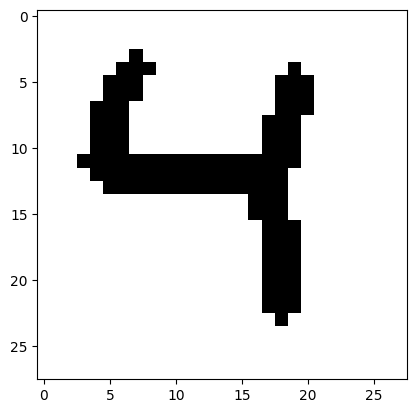

In [10]:
# анализ рукописной цифры

# загрузка изображения и запись значений пикселей в массив
img_array = imageio.imread("PNG/number_4.png", mode='F')
img_data = 255.0 - img_array.reshape(784) 
img_data = (img_data / 255.0 * 0.99) + 0.01

# получения значений выходных узлов
outputs = neural.quary(img_data)

# получение финального ответа
label = numpy.argmax(outputs)
print(label, "- ответ сети", "\n")

#вывод финального изображения
plt.imshow(img_data.reshape(28, 28), cmap='Greys', interpolation='None')

[0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01]


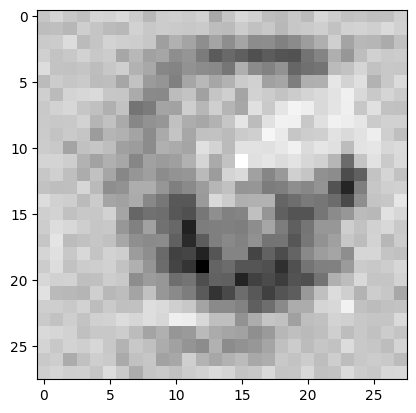

In [11]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 6
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = neural.backquery(targets)

# plot image data
plt.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')